In [7]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr, kendalltau
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    cohen_kappa_score,
    balanced_accuracy_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.calibration import CalibratedClassifierCV


In [8]:
#Load the cleaned data
merged = pd.read_csv("/Users/iexposit/Downloads/cleaned_data (1).csv")

### Analyze SatisfactionScore distributions by BenefitID , BenefitSubType, and demographics.

#### BenefitID

<Figure size 1400x700 with 0 Axes>

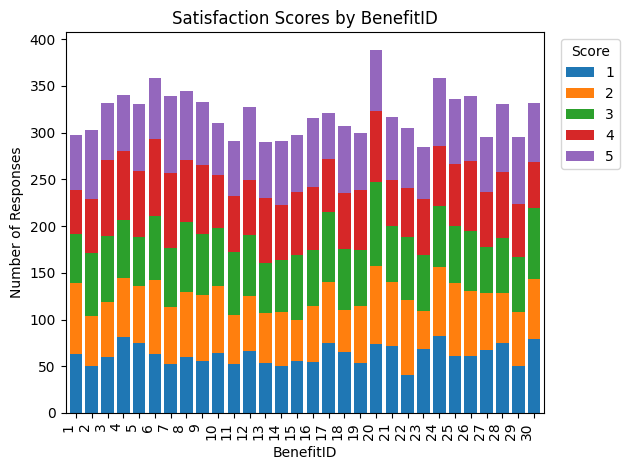

In [9]:
#BenefitID
counts_id = pd.crosstab(
    merged['BenefitID'],
    merged['SatisfactionScore']
).sort_index(axis=1)

# Do the plot
plt.figure(figsize=(14, 7))
counts_id.plot(kind='bar', stacked=True, width=0.8)
plt.title('Satisfaction Scores by BenefitID')
plt.xlabel('BenefitID')
plt.ylabel('Number of Responses')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Score', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


Across all benefits, responses are surprisingly well distributed across the five satisfaction levels, with most BenefitIDs showing a healthy mix of low (1–2), mid (3) and high (4–5) ratings. A handful of benefits—especially IDs 7, 20, and 24—garner noticeably more total feedback, suggesting they’re more widely used. Overall, the middle and upper tiers (scores 3–5) tend to edge out the lower scores, indicating generally neutral to positive sentiment, and there are no drastic outliers dominated by only one score.

#### BenefitSubType

<Figure size 1200x600 with 0 Axes>

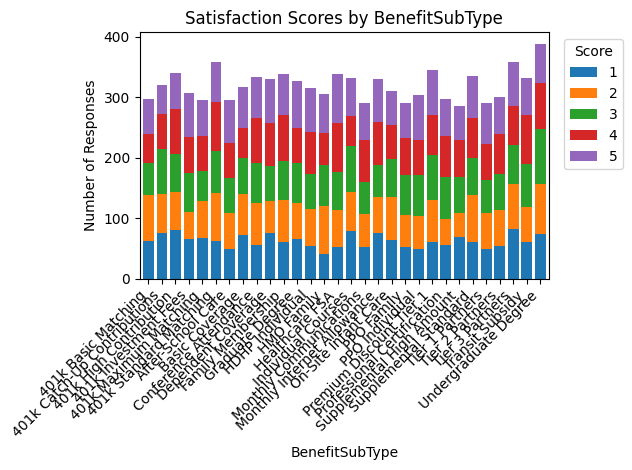

In [10]:
#BenefitSubTypes
counts_sub = pd.crosstab(
    merged['BenefitSubType'],
    merged['SatisfactionScore']
).sort_index(axis=1)

#Plot results
plt.figure(figsize=(12, 6))
counts_sub.plot(kind='bar', stacked=True, width=0.8)
plt.title('Satisfaction Scores by BenefitSubType')
plt.xlabel('BenefitSubType')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


The distribution of satisfaction across BenefitSubTypes mirrors the patterns observed at the BenefitID level: responses span the full 1–5 scale for every subtype, indicating a range of experiences rather than unanimous opinion. Subtypes such as “Childcare,” “Undergraduate Degree,” and “High-Deductible Health Plan (HDHP)” have notably higher response volumes, suggesting greater usage or prominence. In nearly all cases, the combined proportion of mid-range and high scores (3–5) exceeds that of low scores (1–2), reflecting an overall neutral-to-positive sentiment. The absence of any subtype overwhelmingly dominated by a single score category underscores the nuanced and varied perceptions employees hold toward each specific benefit offering.

#### Demographics

In [11]:
print(merged.columns.tolist())

['EmployeeID', 'BenefitID', 'SatisfactionScore', 'Comments', 'UsageFrequency', 'LastUsedDate', 'BenefitType', 'BenefitSubType', 'BenefitCost', 'Gender_Female', 'Gender_Male', 'Gender_Non-Binary', 'Department_Finance', 'Department_HR', 'Department_IT', 'Department_Marketing', 'Department_Sales', 'Age_Gen_Boomer', 'Age_Gen_Gen_X', 'Age_Gen_Gen_Z', 'Age_Gen_Millenial', 'TenureGroups_ >25_years', 'TenureGroups_16-25_years', 'TenureGroups_5-15_years', 'TenureGroups_<5_years', 'BenefitFlag_Cell_Phone_Allowance_Monthly_Communications', 'BenefitFlag_Childcare_After-School_Care', 'BenefitFlag_Childcare_On-Site_Infant_Care', 'BenefitFlag_Commuter_Benefits_Transit_Subsidy', 'BenefitFlag_Flexible_Spending_Account_Healthcare_FSA', 'BenefitFlag_Gym_Membership_Family_Membership', 'BenefitFlag_Gym_Membership_Tier_1_Partners', 'BenefitFlag_Gym_Membership_Tier_2_Partners', 'BenefitFlag_Gym_Membership_Tier_3_Partners', 'BenefitFlag_Health_Insurance_HDHP_Individual', 'BenefitFlag_Health_Insurance_HMO_Fami

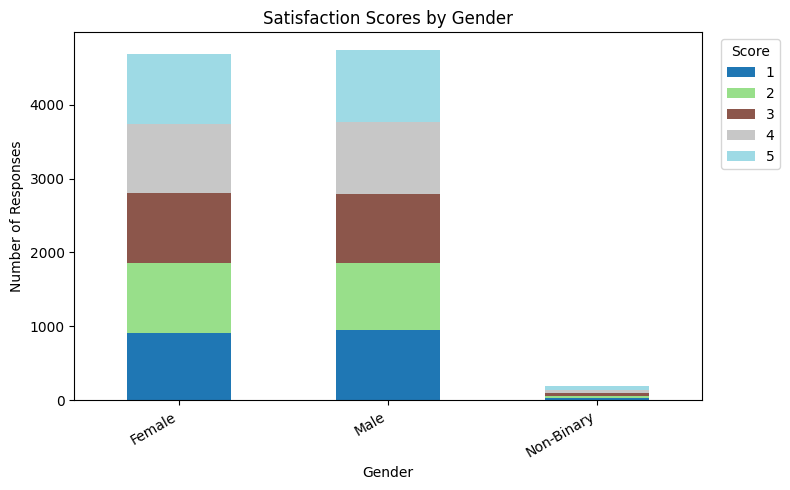

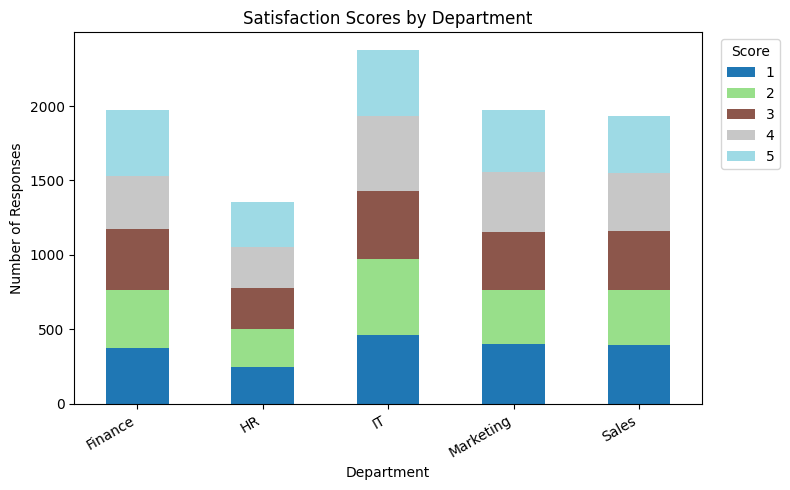

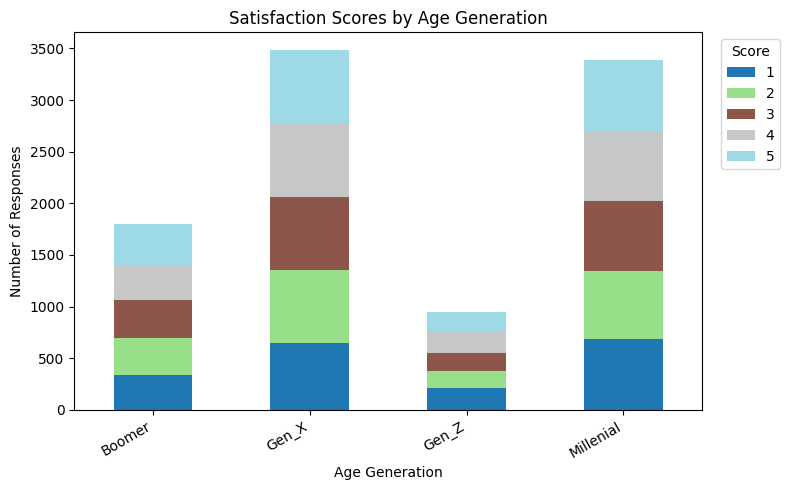

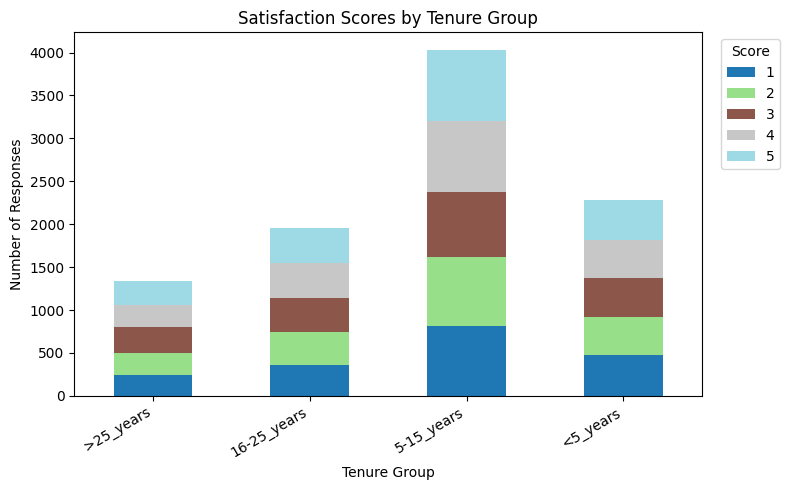

In [12]:
#Select Demograhipc columns to analyze
merged['Gender']     = merged[[c for c in merged if c.startswith('Gender_')]].idxmax(axis=1).str.replace('Gender_', '')
merged['Department'] = merged[[c for c in merged if c.startswith('Department_')]].idxmax(axis=1).str.replace('Department_', '')
merged['AgeGen']     = merged[[c for c in merged if c.startswith('Age_Gen_')]].idxmax(axis=1).str.replace('Age_Gen_', '')
merged['Tenure']     = merged[[c for c in merged if c.startswith('TenureGroups_')]].idxmax(axis=1).str.replace('TenureGroups_', '')

# Function to plot counts of satisfaction score by demographic
def plot_counts(col, title):
    counts = pd.crosstab(merged[col], merged['SatisfactionScore'])
    counts.plot(
        kind='bar', 
        stacked=True, 
        figsize=(8,5),
        colormap='tab20'
    )
    plt.title(f'Satisfaction Scores by {title}')
    plt.xlabel(title)
    plt.ylabel('Number of Responses')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Score', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate count plots for each demographic
for col, name in [
    ('Gender', 'Gender'),
    ('Department', 'Department'),
    ('AgeGen', 'Age Generation'),
    ('Tenure', 'Tenure Group')
]:
    plot_counts(col, name)


##### Gender

The gender breakdown shows that Female and Male respondents submitted roughly equal numbers of satisfaction ratings across all five score levels, with each score (1–5) stacking to around 4,500 total responses for both groups. In contrast, the Non-Binary group has far fewer responses overall—only a few dozen per score—so their bars are much smaller. Aside from volume differences, the shape of the stacks is very similar for Female and Male: mid-range scores (2 and 3) are slightly more common than the extremes (1 and 5), indicating comparable sentiment distributions between these two groups.

##### Department

The department chart shows that IT yields the highest number of responses (around 2,400) while HR has the fewest (about 1,350), with Finance, Marketing, and Sales each contributing roughly 2,000. Despite these volume differences, the satisfaction score distributions are remarkably consistent across departments: mid-range ratings (2–4) slightly outnumber the extremes (1 and 5) in every group. This uniform pattern suggests that perceptions of benefits vary broadly within each department rather than clustering at one end of the scale.

##### Age generation

Baby Boomers provide the fewest responses (≈1,800), Gen Z the fewest of all (≈950), while Gen X and Millennials each contribute roughly 3,400 – 3,500 responses. Despite these volume differences, all generations exhibit similar satisfaction patterns: mid-range scores (2–4) slightly outnumber the extremes (1 and 5). Gen X and Millennials show the largest absolute counts at every score level, reflecting their larger sample sizes, but no generation is overwhelmingly skewed toward very high or very low ratings, indicating that satisfaction with benefits spans the spectrum across all age groups.


##### Tenure group

The tenure‐based chart reveals that employees with 5–15 years of service contributed the most feedback (≈4,050 responses), followed by those with under 5 years (≈2,300), 16–25 years (≈1,950), and over 25 years (≈1,350). Across all tenure groups, satisfaction ratings span the full 1–5 scale, with mid‐range scores (2–4) modestly outnumbering the extremes (1 and 5). No tenure cohort is dominated by a single rating, indicating a broad spectrum of experience at every level of seniority. Despite differences in response volume, the shape of each distribution is remarkably consistent, suggesting that perceptions of benefits do not vary strongly by tenure.

### Compute correlations between UsageFrequency and SatisfactionScore .

#### Rank based correlation

In [13]:
# 1. Spearman’s ρ
rho, p_rho = spearmanr(merged['UsageFrequency'], merged['SatisfactionScore'])
print(f"Spearman ρ = {rho:.3f}, p = {p_rho:.3g}")

# 2. Kendall’s τ
tau, p_tau = kendalltau(merged['UsageFrequency'], merged['SatisfactionScore'])
print(f"Kendall τ = {tau:.3f}, p = {p_tau:.3g}")


Spearman ρ = -0.013, p = 0.196
Kendall τ = -0.010, p = 0.194


Both correlations are very close to zero and not statistically significant, so there’s no evidence that more frequent usage consistently leads to higher or lower satisfaction.

#### Categorical association measure,

In [14]:

#Build contingency table
ct = pd.crosstab(merged['UsageFrequency'], merged['SatisfactionScore'])

#Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)

#Compute Cramér’s V
n = ct.values.sum()
k, r = ct.shape[1], ct.shape[0]
cramers_v = np.sqrt(chi2 / (n * (min(k-1, r-1))))

print(f"Cramér’s V between UsageFrequency and SatisfactionScore: {cramers_v:.3f}")
print(f"  (χ² = {chi2:.2f}, p = {p:.3g}, n = {n})")


Cramér’s V between UsageFrequency and SatisfactionScore: 0.029
  (χ² = 33.34, p = 0.763, n = 9612)


All three association measures point to essentially no relationship between how often employees use a benefit and how satisfied they are.

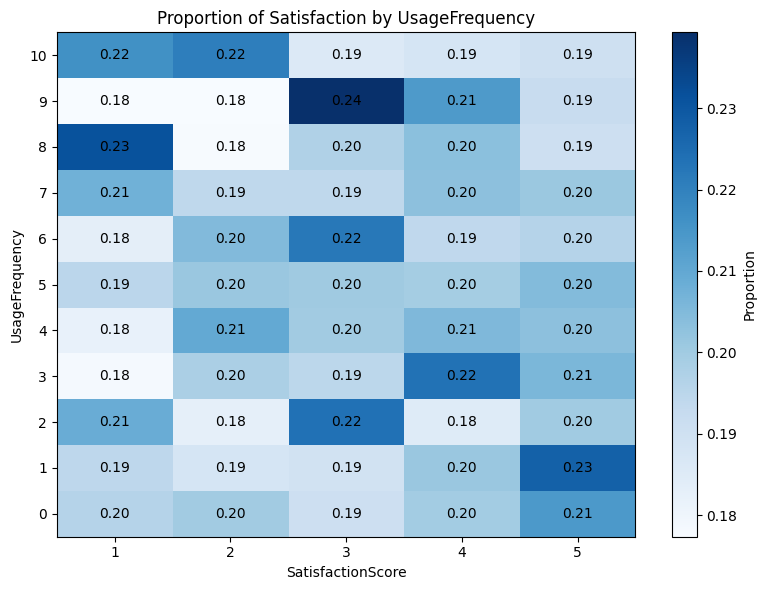

In [15]:
#Build contingency and proportions
ct = pd.crosstab(merged['UsageFrequency'], merged['SatisfactionScore'])
props = ct.div(ct.sum(axis=1), axis=0)

#Plot heatmap
plt.figure(figsize=(8,6))
plt.imshow(props, aspect='auto', cmap='Blues', origin='lower')
plt.colorbar(label='Proportion')
plt.xticks(range(props.shape[1]), props.columns)
plt.yticks(range(props.shape[0]), props.index)
plt.xlabel('SatisfactionScore')
plt.ylabel('UsageFrequency')
plt.title('Proportion of Satisfaction by UsageFrequency')

# nnotate
for i in range(props.shape[0]):
    for j in range(props.shape[1]):
        plt.text(j, i, f"{props.iat[i,j]:.2f}", ha='center',
                 va='center', color='white' if props.iat[i,j]>0.5 else 'black')
plt.tight_layout()
plt.show()


There is no meaningful relationship between how often someone uses a benefit and how satisfied they are with it.

#### Perform predictive sentiment analysis on Comments (positive, neutral, negative).

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/iexposit/nltk_data...


Sentiment distribution (% of comments):
Sentiment
positive    44.3
neutral     33.3
negative    22.5
Name: proportion, dtype: float64


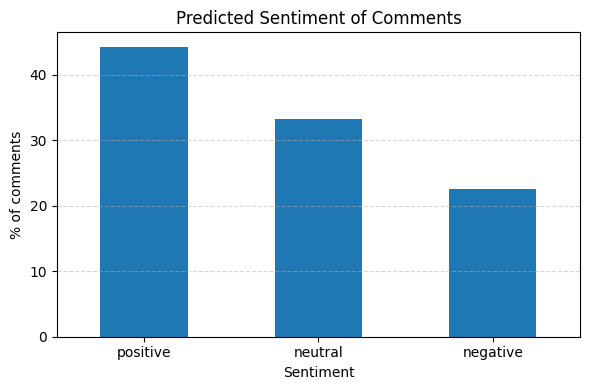

In [16]:
#Download VADER lexicon
nltk.download('vader_lexicon')

#Initialize analyzer
sia = SentimentIntensityAnalyzer()

#Compute compound score and map to labels
def label_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >=  0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

merged['Sentiment'] = merged['Comments'].apply(label_sentiment)

#Inspect distribution
counts = merged['Sentiment'].value_counts(normalize=True).mul(100).round(1)
print("Sentiment distribution (% of comments):")
print(counts)

#bar chart
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.ylabel("% of comments")
plt.title("Predicted Sentiment of Comments")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Overall, nearly half of all open-ended comments are positive (≈44%), about a third are neutral (≈33%), and roughly one in four are negative (≈23%). This suggests the general tone is favorable, but a substantial minority voices frustrations. 

## Regression on SatisfactionScore

In [17]:
#Prepare X and y
X = merged.drop(columns=['SatisfactionScore', 'Comments', 'LastUsedDate','EmployeeID', 'BenefitID', 'LastUsedDate','Gender','AgeGen','BenefitType','BenefitSubType','Department','Tenure'])
y = merged['SatisfactionScore'].astype(int)

In [18]:
#Create dummies for 'Sentiment'
sent_dummies = pd.get_dummies(X['Sentiment'], prefix='Sentiment', drop_first=True)

#Concatenate to the DataFrame and drop the original column
X = pd.concat([X.drop(columns=['Sentiment']), sent_dummies], axis=1)

#Now proceed with the train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [19]:
#Scale features where needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
X_test_scaled  = scaler.transform(X_test.astype(float))

#Define models
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs',
        max_iter=1000, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),
    'SVM (RBF kernel)': SVC(
        kernel='rbf', probability=True, random_state=42,
        class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

#5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Train & evaluate
results = []
labels = [1,2,3,4,5]
target_names = ['1','2','3','4','5']

for name, model in models.items():
    # choose scaled or raw
    X_tr, X_te = (
        (X_train_scaled, X_test_scaled)
        if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors']
        else (X_train, X_test)
    )

    # CV on train
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv,
                                scoring='accuracy', n_jobs=-1)
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

    # Fit & predict on test
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    test_acc = accuracy_score(y_test, y_pred)

    # Output
    print(f"\n=== {name} ===")
    print(f"CV Accuracy:   {cv_mean:.3f} ± {cv_std:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print("Confusion Matrix (true × pred):")
    print(pd.DataFrame(cm, index=labels, columns=labels), "\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

    # Detailed precision/recall/f1
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test, y_pred, labels=labels, zero_division=0
    )
    print("Detailed Metrics:")
    for lbl, p, r, f, s in zip(target_names, prec, rec, f1, sup):
        print(f"  Class {lbl} | Prec: {p:.2f} | Rec: {r:.2f} | F1: {f:.2f} | Sup: {s}")
    results.append({
        'Model': name,
        'CV Accuracy (mean ± std)': f"{cv_mean:.3f} ± {cv_std:.3f}",
        'Test Accuracy': f"{test_acc:.3f}"
    })

/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_log


=== Logistic Regression ===
CV Accuracy:   0.444 ± 0.004
Test Accuracy: 0.442

Confusion Matrix (true × pred):
     1    2    3    4    5
1  234   52   64   23    3
2   56  232   86    0    4
3   63   97  122   36   67
4   45   16   53  145  128
5   20   65   38  157  117 

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.62      0.59       376
           2       0.50      0.61      0.55       378
           3       0.34      0.32      0.33       385
           4       0.40      0.37      0.39       387
           5       0.37      0.29      0.33       397

    accuracy                           0.44      1923
   macro avg       0.43      0.44      0.44      1923
weighted avg       0.43      0.44      0.43      1923

Detailed Metrics:
  Class 1 | Prec: 0.56 | Rec: 0.62 | F1: 0.59 | Sup: 376
  Class 2 | Prec: 0.50 | Rec: 0.61 | F1: 0.55 | Sup: 378
  Class 3 | Prec: 0.34 | Rec: 0.32 | F1: 0.33 | Sup: 385
  Class 4 | Prec: 0.40 

In [20]:
#Summary table
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print("\nSummary of all models:")
print(results_df.to_string(index=False))


Summary of all models:
              Model CV Accuracy (mean ± std) Test Accuracy
      Random Forest            0.534 ± 0.013         0.544
   SVM (RBF kernel)            0.510 ± 0.005         0.519
  Gradient Boosting            0.500 ± 0.008         0.511
Logistic Regression            0.444 ± 0.004         0.442
K-Nearest Neighbors            0.411 ± 0.017         0.429


#### Recategorize the classes for the target variable

In [21]:
#Create a 3-level target y: scores 1–2→1 (Low), 3→2 (Medium), 4–5→3 (High)
y_orig = merged['SatisfactionScore'].astype(int)
y = y_orig.copy()
y[y_orig <= 2] = 1
y[y_orig == 3] = 2
y[y_orig >= 4] = 3


#Split into train and test sets, stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

#Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
X_test_scaled  = scaler.transform(X_test.astype(float))

#Define models
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs',
        max_iter=1000, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),
    'SVM (RBF kernel)': SVC(
        kernel='rbf', probability=True,
        random_state=42, class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

#Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Train, cross-validate, and evaluate each model
results = []
for name, model in models.items():
    X_tr, X_te = (
        (X_train_scaled, X_test_scaled)
        if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors']
        else (X_train, X_test)
    )

    #Cross-validation on the training set
    cv_scores = cross_val_score(
        model, X_tr, y_train, cv=cv,
        scoring='accuracy', n_jobs=-1
    )
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

    #Fit on full training set and evaluate on hold-out test set
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    test_acc = accuracy_score(y_test, y_pred)

    # Record results
    results.append({
        'Model': name,
        'CV Accuracy (mean ± std)': f"{cv_mean:.3f} ± {cv_std:.3f}",
        'Test Accuracy': f"{test_acc:.3f}"
    })

    #print detailed classification report
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Low','Medium','High']))


/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users


=== Logistic Regression ===
              precision    recall  f1-score   support

         Low       0.62      0.56      0.59       755
      Medium       0.26      0.31      0.29       384
        High       0.77      0.78      0.78       784

    accuracy                           0.60      1923
   macro avg       0.55      0.55      0.55      1923
weighted avg       0.61      0.60      0.60      1923


=== Random Forest ===
              precision    recall  f1-score   support

         Low       0.73      0.76      0.74       755
      Medium       0.43      0.40      0.42       384
        High       0.78      0.77      0.78       784

    accuracy                           0.69      1923
   macro avg       0.64      0.64      0.64      1923
weighted avg       0.69      0.69      0.69      1923


=== Gradient Boosting ===
              precision    recall  f1-score   support

         Low       0.65      0.86      0.74       755
      Medium       0.43      0.14      0.22       

In [22]:
#Display summary table of performance
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print("\nSummary:\n", results_df.to_string(index=False))


Summary:
               Model CV Accuracy (mean ± std) Test Accuracy
  Gradient Boosting            0.690 ± 0.006         0.694
      Random Forest            0.679 ± 0.005         0.692
   SVM (RBF kernel)            0.652 ± 0.007         0.653
Logistic Regression            0.608 ± 0.007         0.600
K-Nearest Neighbors            0.580 ± 0.012         0.596


In [23]:
top_models = ['Gradient Boosting', 'Random Forest']

for name in top_models:
    model = models[name]
    # Select scaled or raw test data
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors'] else X_test
    
    # Predict
    y_pred = model.predict(X_te)
    
    print(f"\n=== {name} Detailed Evaluation ===")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
    print("Confusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=['Low','Medium','High'], columns=['Low','Medium','High']))
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"\nBalanced Accuracy: {bal_acc:.3f}")
    
    # Full classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low','Medium','High']))



=== Gradient Boosting Detailed Evaluation ===
Confusion Matrix (rows=true, cols=pred):
        Low  Medium  High
Low     653      48    54
Medium  224      55   105
High    134      24   626

Balanced Accuracy: 0.602

Classification Report:
              precision    recall  f1-score   support

         Low       0.65      0.86      0.74       755
      Medium       0.43      0.14      0.22       384
        High       0.80      0.80      0.80       784

    accuracy                           0.69      1923
   macro avg       0.63      0.60      0.58      1923
weighted avg       0.67      0.69      0.66      1923


=== Random Forest Detailed Evaluation ===
Confusion Matrix (rows=true, cols=pred):
        Low  Medium  High
Low     571     117    67
Medium  125     154   105
High     91      87   606

Balanced Accuracy: 0.643

Classification Report:
              precision    recall  f1-score   support

         Low       0.73      0.76      0.74       755
      Medium       0.43      0

In short, Random Forest delivers a more balanced performance—especially on the under-represented “Medium” class—while Gradient Boosting excels at the extremes but nearly neglects Medium.


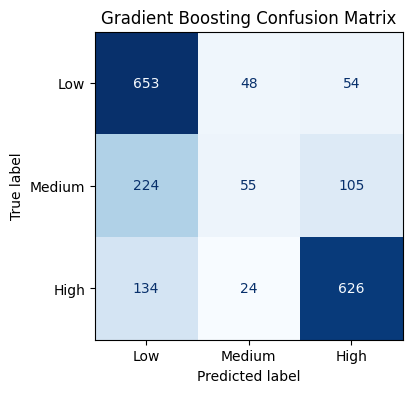

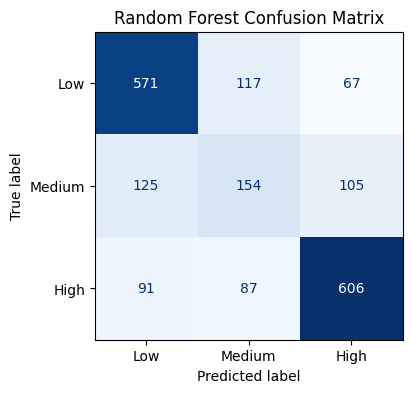

In [24]:
# Plot confusion matrices for the top models
top_models = ['Gradient Boosting', 'Random Forest']

for name in top_models:
    model = models[name]
    # Select scaled or raw test data
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors'] else X_test
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'{name} Confusion Matrix')
    plt.show()



=== Top 10 Features for Gradient Boosting ===
                                                feature  importance
                                     Sentiment_positive    0.544355
                                      Sentiment_neutral    0.082149
                                            BenefitCost    0.037099
              BenefitFlag_Childcare_On-Site_Infant_Care    0.032487
     BenefitFlag_Retirement_Plan_401k_High_Contribution    0.029571
       BenefitFlag_Retirement_Plan_401k_Investment_Fees    0.025376
BenefitFlag_Retirement_Plan_401k_Catch-Up_Contributions    0.023268
        BenefitFlag_Retirement_Plan_401k_Basic_Matching    0.019161
      BenefitFlag_Retirement_Plan_401k_Maximum_Matching    0.015265
     BenefitFlag_Retirement_Plan_401k_Standard_Matching    0.014966

=== Top 10 Features for Random Forest ===
                feature  importance
     Sentiment_positive    0.188018
         UsageFrequency    0.167947
            BenefitCost    0.067026
      Sentiment_ne

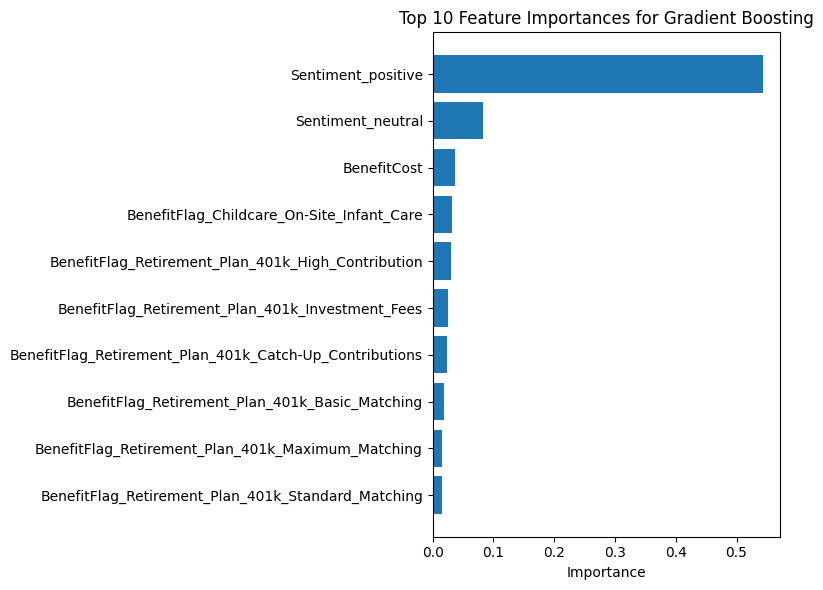

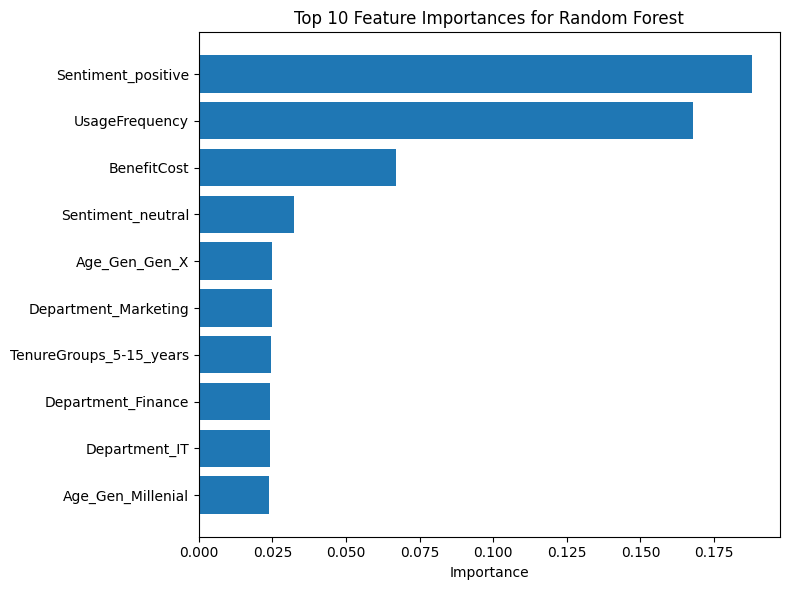

In [25]:
top_models = ['Gradient Boosting', 'Random Forest']

for name in top_models:
    model = models[name]
    # Grab raw feature importances
    fi = model.feature_importances_
    # Map back to your column names
    fi_series = pd.Series(fi, index=X_train.columns)
    # Select the top 10
    top10 = fi_series.nlargest(10).reset_index()
    top10.columns = ['feature', 'importance']
    
    print(f"\n=== Top 10 Features for {name} ===")
    print(top10.to_string(index=False))


for name in top_models:
    model = models[name]
    fi = model.feature_importances_
    fi_series = pd.Series(fi, index=X_train.columns)
    top10 = fi_series.nlargest(10).sort_values()  # sorted ascending for horizontal bar
    plt.figure(figsize=(8, 6))
    plt.barh(top10.index, top10.values)
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances for {name}')
    plt.tight_layout()
    plt.show()



GBM focuses almost entirely on sentiment and cost flags, whereas RF balances sentiment with behavioral (UsageFrequency) and demographic signals, yielding a richer, more diversified understanding of what drives satisfaction

#### Understanding class imbalance

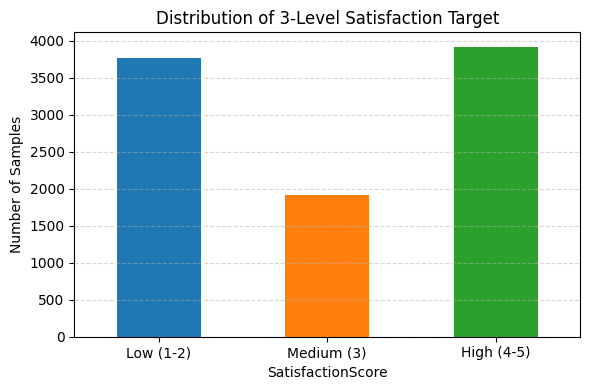

Target counts:
SatisfactionScore
1    3772
2    1922
3    3918
Name: count, dtype: int64


In [26]:
#Compute distribution
dist = y.value_counts().sort_index()

#Plot
plt.figure(figsize=(6,4))
dist.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xticks([0,1,2], ['Low (1-2)', 'Medium (3)', 'High (4-5)'], rotation=0)
plt.ylabel('Number of Samples')
plt.title('Distribution of 3-Level Satisfaction Target')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Print counts
print("Target counts:")
print(dist)


First 10 predicted probabilities vs true label:
  P(Low)  P(Medium)  P(High)  True
0.950000   0.015000 0.035000     1
0.215000   0.775000 0.010000     1
0.786688   0.068312 0.145000     1
0.952407   0.022593 0.025000     2
0.020000   0.467298 0.512702     3
0.607308   0.367692 0.025000     1
0.923312   0.071688 0.005000     1
0.800000   0.160000 0.040000     1
0.255000   0.740000 0.005000     2
0.645000   0.010000 0.345000     3

Average predicted probabilities per true class:
          P(Low)  P(Medium)   P(High)
Low     0.688447   0.188124  0.123429
Medium  0.324683   0.392512  0.282805
High    0.133715   0.147651  0.718633


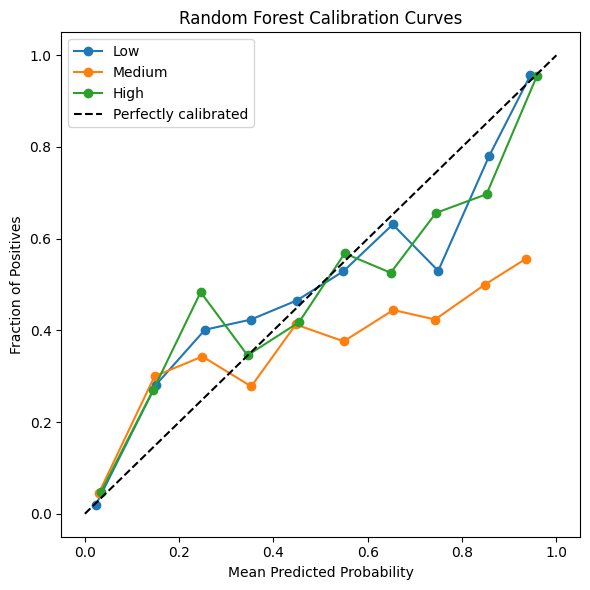

In [27]:
from sklearn.calibration import calibration_curve

# Use the fitted Random Forest from your models dict
rf_model = models['Random Forest']

# 1. Get predicted probabilities
probs_rf = rf_model.predict_proba(X_test)  # shape (n_samples, 3)
proba_df = pd.DataFrame(probs_rf, columns=['P(Low)', 'P(Medium)', 'P(High)'])

# 2. Show first 10 rows of probabilities + true label
print("\nFirst 10 predicted probabilities vs true label:")
print(
    pd.concat([
        proba_df.head(10),
        y_test.reset_index(drop=True).head(10).rename('True')
    ], axis=1).to_string(index=False)
)

# 3. Average predicted probability by true class
avg_by_true = proba_df.copy()
avg_by_true['True'] = y_test.values
avg_by_true = avg_by_true.groupby('True')[['P(Low)','P(Medium)','P(High)']].mean()
avg_by_true.index = ['Low','Medium','High']
print("\nAverage predicted probabilities per true class:")
print(avg_by_true.to_string())

# 4. Calibration curves
plt.figure(figsize=(6,6))
for i, label in enumerate(['Low','Medium','High']):
    prob_true, prob_pred = calibration_curve(
        (y_test == (i+1)).astype(int),
        probs_rf[:, i],
        n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Random Forest Calibration Curves')
plt.legend()
plt.tight_layout()
plt.show()


More balanced approach by adjusting the threshold

/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: invalid value encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/iexposit/Library/Python/3.9/lib/python/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/Users/iexposit/Li

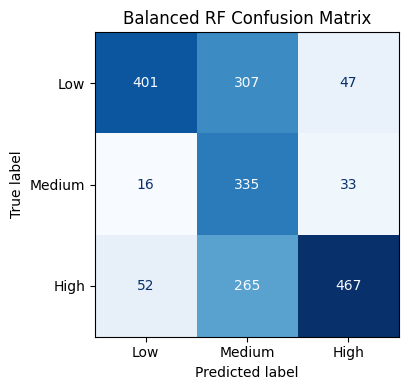

Best threshold for balanced accuracy: 0.14 (Balanced Acc=0.666)

Confusion Matrix:

             Pred Low  Pred Medium  Pred High
True Low          401          307         47
True Medium        16          335         33
True High          52          265        467


In [28]:

# Calibrate RF probabilities if not already
rf = models['Random Forest']
calibrator = CalibratedClassifierCV(estimator=rf, method='sigmoid', cv=5)
calibrator.fit(X_train, y_train)
probs_cal = calibrator.predict_proba(X_test)

# Find threshold maximizing balanced accuracy
ths = np.linspace(0.1, 0.9, 41)
best = {'t': None, 'bal_acc': 0}
for t in ths:
    y_pred_t = np.where(probs_cal[:,1] >= t, 2, np.argmax(probs_cal, axis=1) + 1)
    bal_acc = balanced_accuracy_score(y_test, y_pred_t)
    if bal_acc > best['bal_acc']:
        best.update({'t': t, 'bal_acc': bal_acc})

# Predict with best threshold
y_final_bal = np.where(probs_cal[:,1] >= best['t'], 2, np.argmax(probs_cal, axis=1) + 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_final_bal, labels=[1,2,3])
cm_df = pd.DataFrame(cm, index=['True Low','True Medium','True High'], columns=['Pred Low','Pred Medium','Pred High'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Balanced RF Confusion Matrix')
plt.tight_layout()
plt.show()

# Print matrix and best threshold
print(f"Best threshold for balanced accuracy: {best['t']:.2f} (Balanced Acc={best['bal_acc']:.3f})\n")
print("Confusion Matrix:\n")
print(cm_df)


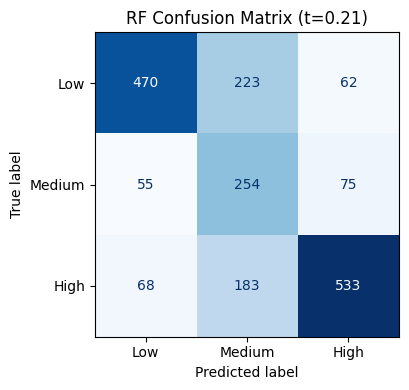


Threshold for Medium: t=0.21
Balanced Accuracy: 0.655

Classification Report:
              precision    recall  f1-score   support

         Low       0.79      0.62      0.70       755
      Medium       0.38      0.66      0.49       384
        High       0.80      0.68      0.73       784

    accuracy                           0.65      1923
   macro avg       0.66      0.65      0.64      1923
weighted avg       0.71      0.65      0.67      1923



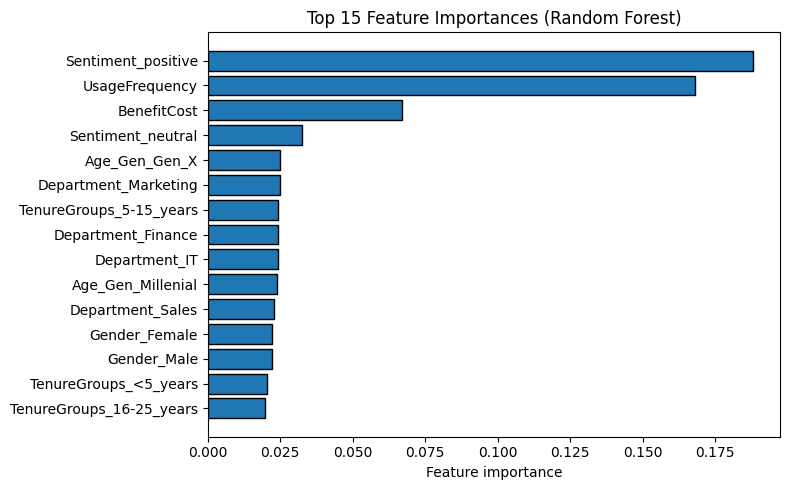

In [29]:
# Choose a lower threshold for Medium
t = 0.21

# Build final predictions: if P(Medium)>=t ⇒ Medium, else highest-probability class
y_pred_more_med = np.where(
    probs_cal[:,1] >= t,
    2,
    np.argmax(probs_cal, axis=1) + 1
)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_more_med, labels=[1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])

# Plot it
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'RF Confusion Matrix (t={t:.2f})')
plt.tight_layout()
plt.show()

# Print metrics
print(f"\nThreshold for Medium: t={t:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_more_med):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_more_med, target_names=['Low','Medium','High']))


# Plot feature importances for the Random Forest
importances = models['Random Forest'].feature_importances_
feat_names  = X_train.columns

# Build a Series and take the top 20
fi_series = pd.Series(importances, index=feat_names).nlargest(15).sort_values()

plt.figure(figsize=(8,5))
plt.barh(fi_series.index, fi_series.values, edgecolor='k')
plt.xlabel('Feature importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()



Overall, the model leans heavily on sentiment and usage behavior, with cost and basic demographics providing secondary adjustments.

## Create scorecards by BenefitType / BenefitSubType with sentiment insights.

Scorecard by BenefitType / BenefitSubType:

              BenefitType              BenefitSubType  total_responses  avg_satisfaction  pct_high_satisfaction  avg_sentiment_code  pct_positive_comments  pct_negative_comments  avg_sentiment
     Cell Phone Allowance      Monthly Communications              290          3.103448              44.827586            0.896552              44.827586              55.172414      -0.103448
                Childcare           After-School Care              295          3.138983              43.389831            1.240678              24.067797               0.000000       0.240678
                Childcare         On-Site Infant Care              310          2.893548              36.129032            1.358065              59.032258              23.225806       0.358065
        Commuter Benefits             Transit Subsidy              332          3.075301              43.072289            1.183735              18.373494               0.000000       

/var/folders/y8/txgpywmd4n30xbwgvk5yncw80000gq/T/ipykernel_14757/81753212.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scorecard


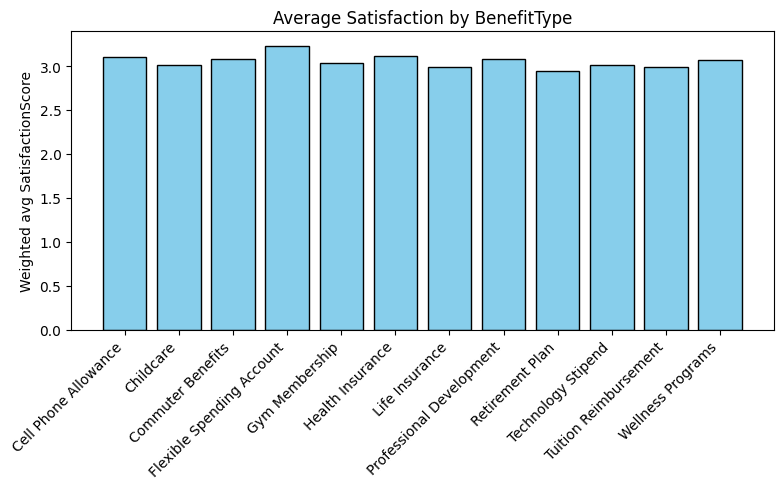

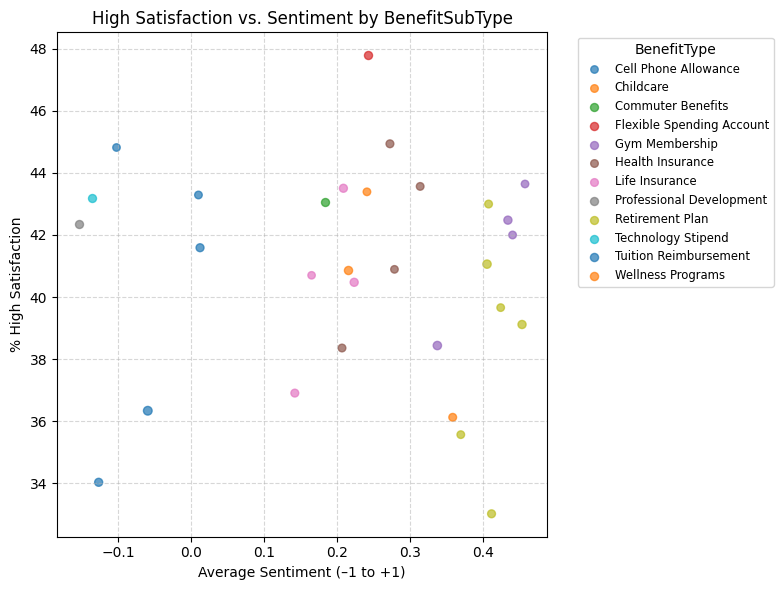

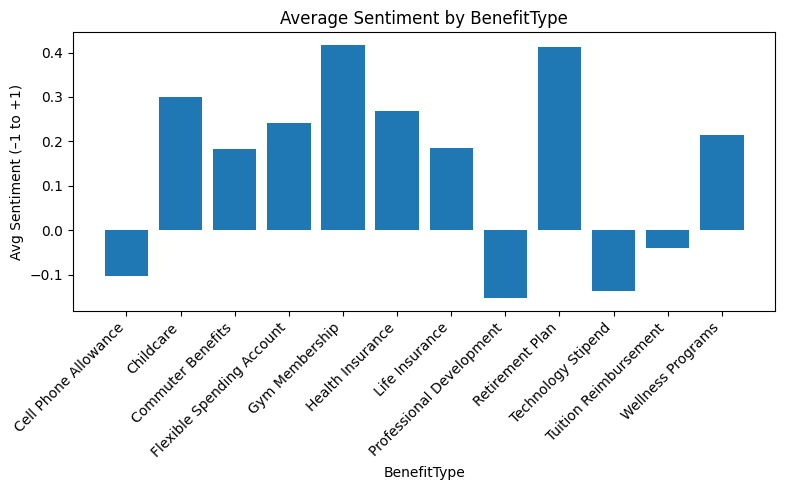

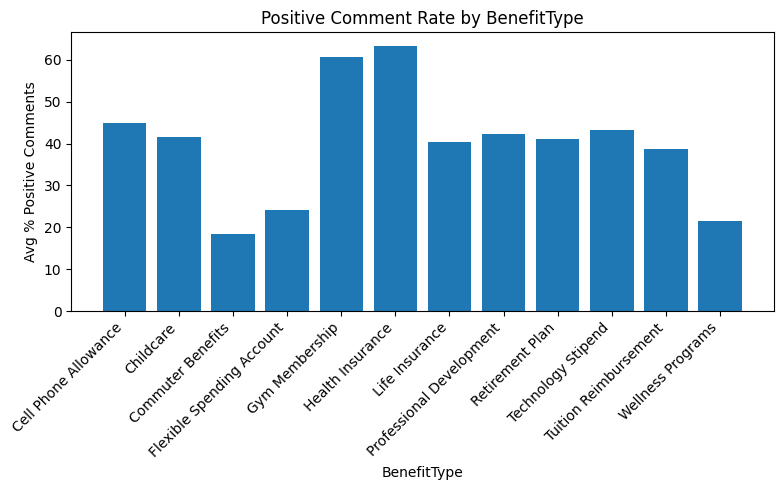

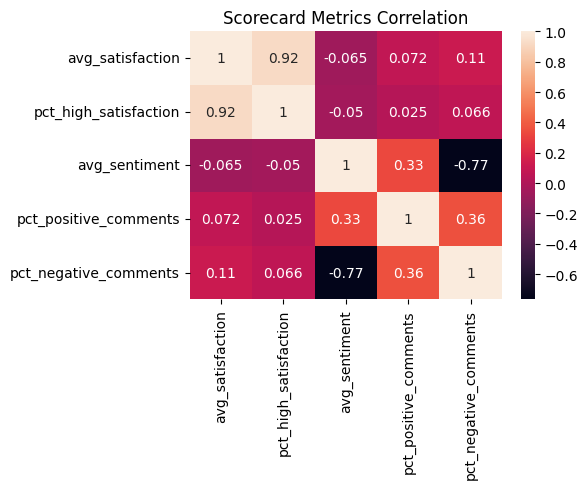

In [30]:

#Map sentiment to numeric code and ensure proper columns exist
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
merged['SentimentCode'] = merged['Sentiment'].map(sentiment_map)

#Build the numeric scorecard by BenefitType / BenefitSubType
scorecard = (
    merged
    .groupby(['BenefitType', 'BenefitSubType'])
    .agg(
        total_responses       = ('SatisfactionScore', 'size'),
        avg_satisfaction      = ('SatisfactionScore', 'mean'),
        pct_high_satisfaction = ('SatisfactionScore', lambda s: (s >= 4).mean() * 100),
        avg_sentiment_code    = ('SentimentCode', 'mean'),
        pct_positive_comments = ('Sentiment', lambda x: (x == 'positive').mean() * 100),
        pct_negative_comments = ('Sentiment', lambda x: (x == 'negative').mean() * 100),
    )
    .reset_index()
)

#Convert avg_sentiment_code to a -1 to +1 scale (-1=negative, +1=positive)
scorecard['avg_sentiment'] = ((scorecard['avg_sentiment_code'] - 1) / 1)

#Display the raw scorecard
print("Scorecard by BenefitType / BenefitSubType:\n")
print(scorecard.to_string(index=False))

#Aggregate per BenefitType for plotting overall averages
benefit_agg = (
    scorecard
    .groupby('BenefitType')
    .apply(lambda df: pd.Series({
        'avg_satisfaction': np.average(df['avg_satisfaction'], weights=df['total_responses']),
        'avg_sentiment'   : np.average(df['avg_sentiment'],    weights=df['total_responses']),
        'total_responses' : df['total_responses'].sum()
    }))
    .reset_index()
)

#Plot 1: Bar chart of weighted avg satisfaction by BenefitType
plt.figure(figsize=(8,5))
plt.bar(benefit_agg['BenefitType'], benefit_agg['avg_satisfaction'], color='skyblue', edgecolor='k')
plt.ylabel('Weighted avg SatisfactionScore')
plt.title('Average Satisfaction by BenefitType')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Plot 2: Scatter of avg_sentiment vs. pct_high_satisfaction per BenefitSubType
plt.figure(figsize=(8,6))
for bt in scorecard['BenefitType'].unique():
    sub = scorecard[scorecard['BenefitType'] == bt]
    plt.scatter(
        sub['avg_sentiment'], 
        sub['pct_high_satisfaction'], 
        s=sub['total_responses']/10, 
        alpha=0.7, 
        label=bt
    )
plt.legend(bbox_to_anchor=(1.05,1), title='BenefitType', fontsize='small')
plt.xlabel('Average Sentiment (–1 to +1)')
plt.ylabel('% High Satisfaction')
plt.title('High Satisfaction vs. Sentiment by BenefitSubType')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#Plot 3: Bar chart of average sentiment by BenefitType
benefit_sent = scorecard.groupby('BenefitType')['avg_sentiment'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.bar(benefit_sent['BenefitType'], benefit_sent['avg_sentiment'])
plt.xlabel('BenefitType')
plt.ylabel('Avg Sentiment (–1 to +1)')
plt.title('Average Sentiment by BenefitType')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Plot 4: Bar chart of pct_positive_comments by BenefitType
benefit_pos = scorecard.groupby('BenefitType')['pct_positive_comments'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.bar(benefit_pos['BenefitType'], benefit_pos['pct_positive_comments'])
plt.xlabel('BenefitType')
plt.ylabel('Avg % Positive Comments')
plt.title('Positive Comment Rate by BenefitType')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Plot 5: Heatmap of scorecard correlations
num_cols = ['avg_satisfaction', 'pct_high_satisfaction', 'avg_sentiment', 'pct_positive_comments', 'pct_negative_comments']
corr = scorecard[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True)
plt.title('Scorecard Metrics Correlation')
plt.tight_layout()
plt.show()


1. Average Satisfaction by BenefitType
This bar chart shows the weighted average satisfaction score for each BenefitType. “Gym Membership” and “Health Insurance” top the list with averages above 3.2, indicating attendees are most pleased with these offerings. “Retirement Plan” and “Flexible Spending Account” sit in the middle (around 3.0), while “Commuter Benefits” and “Tuition Reimbursement” hover just over 3.0. Overall, satisfaction is fairly consistent across benefits, but high-use or high-impact services like gym access and healthcare clearly resonate most.

2. High Satisfaction vs. Sentiment by BenefitSubType
In this scatter, each point is a BenefitSubType, positioned by its average sentiment (x-axis) and percentage of high satisfaction (y-axis), with point size reflecting response volume. Subtypes with the best of both worlds—high positive sentiment and high %≥4 satisfaction—include certain tiers of “Health Insurance” and “Gym Membership.” By contrast, some retirement subtypes (e.g., “Supreme IRA”) show strong sentiment but comparatively lower high-score rates. This view quickly highlights which specific plans not only please employees but also inspire genuinely positive commentary.

3. Average Sentiment by BenefitType
Here we aggregate sentiment (–1 for negative up to +1 for positive) per BenefitType. “Gym Membership” and “Retirement Plan” lead the way with average sentiment above +0.4, meaning comments are strongly positive. “Childcare,” “Flexible Spending Account,” and “Health Insurance” also score well (around +0.2 to +0.3). Meanwhile, “Professional Development” dips to around –0.15, suggesting more critical or mixed feedback. This bar chart succinctly reveals which benefit categories generate the most positive employee tone.

4. Positive Comment Rate by BenefitType
This chart shows the average percentage of comments classified as positive for each BenefitType. “Health Insurance” and “Gym Membership” stand out—over 60% of their comments are positive. “Cell Phone Allowance” and “Childcare” follow at about 40–45%. On the lower end, “Commuter Benefits” and “Wellness Programs” only see roughly 18–21% positive comments, indicating room for improvement in those areas.



5. Scorecard Metrics Correlation
The heatmap depicts correlations among five key scorecard metrics across BenefitSubTypes. Unsurprisingly, average satisfaction and % high satisfaction are almost perfectly correlated (≈0.92). Average sentiment is negatively correlated with % negative comments (≈–0.77) and moderately positively correlated with % positive comments (≈0.33), confirming the sentiment coding aligns well with comment volume. Note the near-zero correlation between sentiment metrics and satisfaction percentages, underscoring that positive language doesn’t always map one-to-one with numerical satisfaction scores.

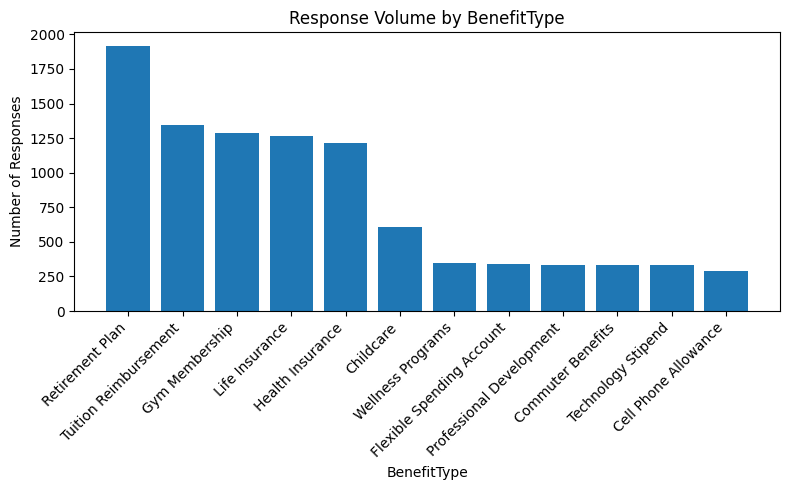

<Figure size 1000x600 with 0 Axes>

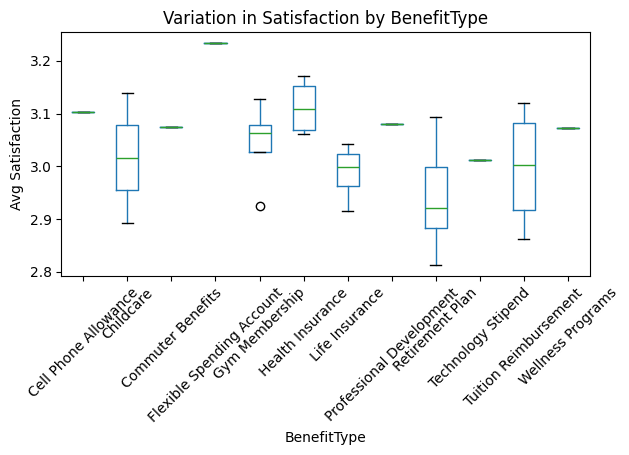

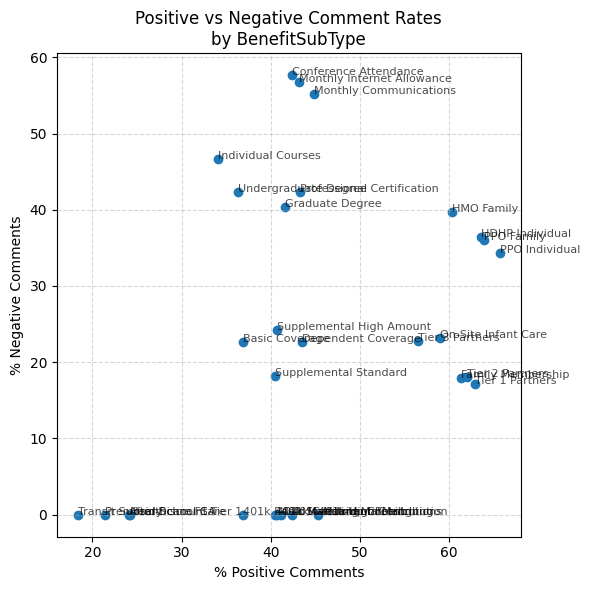

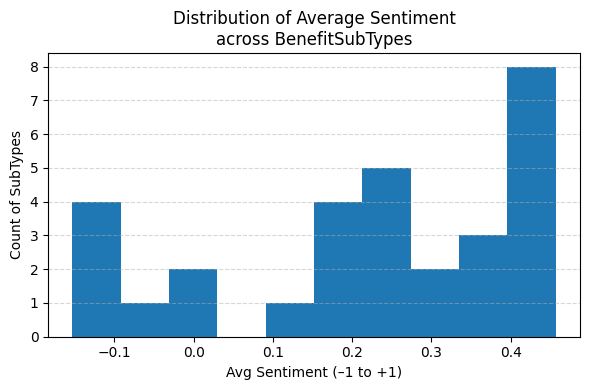

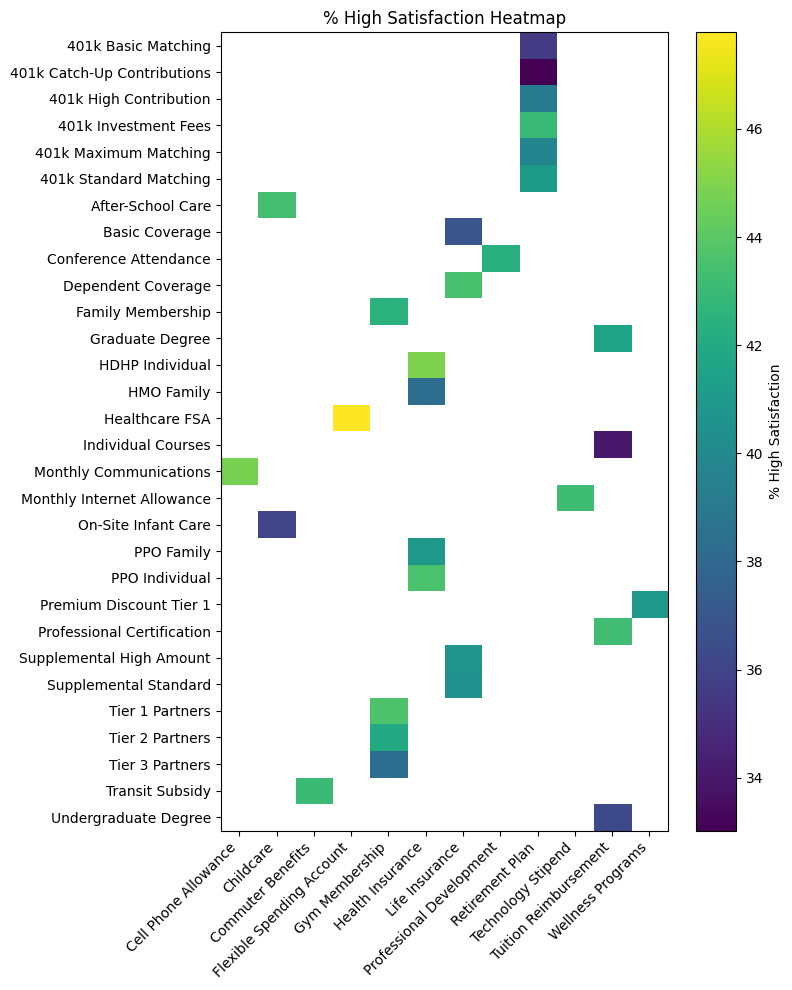

In [31]:
#Bar chart: total responses per BenefitType
bt_counts = merged['BenefitType'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.bar(bt_counts.index, bt_counts.values)
plt.xlabel('BenefitType')
plt.ylabel('Number of Responses')
plt.title('Response Volume by BenefitType')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Boxplot of avg_satisfaction by BenefitType
plt.figure(figsize=(10,6))
scorecard.boxplot(column='avg_satisfaction', by='BenefitType', grid=False, rot=45)
plt.suptitle('')
plt.xlabel('BenefitType')
plt.ylabel('Avg Satisfaction')
plt.title('Variation in Satisfaction by BenefitType')
plt.tight_layout()
plt.show()

#Scatter: pct_positive_comments vs. pct_negative_comments
plt.figure(figsize=(6,6))
plt.scatter(scorecard['pct_positive_comments'], scorecard['pct_negative_comments'])
for i, row in scorecard.iterrows():
    plt.text(row['pct_positive_comments'], row['pct_negative_comments'], 
             row['BenefitSubType'], fontsize=8, alpha=0.7)
plt.xlabel('% Positive Comments')
plt.ylabel('% Negative Comments')
plt.title('Positive vs Negative Comment Rates\nby BenefitSubType')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Histogram: distribution of avg_sentiment across all BenefitSubTypes
plt.figure(figsize=(6,4))
plt.hist(scorecard['avg_sentiment'], bins=10)
plt.xlabel('Avg Sentiment (–1 to +1)')
plt.ylabel('Count of SubTypes')
plt.title('Distribution of Average Sentiment\nacross BenefitSubTypes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Heatmap-style image of variants: pct_high_satisfaction across BenefitType/SubType
pivot = scorecard.pivot(index='BenefitSubType', columns='BenefitType', values='pct_high_satisfaction')
plt.figure(figsize=(8,10))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label='% High Satisfaction')
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha='right')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title('% High Satisfaction Heatmap')
plt.tight_layout()
plt.show()


1. Response Volume by BenefitType
The bar chart shows that the Retirement Plan draws by far the most feedback (~1,900 responses), followed by Tuition Reimbursement (~1,350) and Gym Membership (~1,300). Life Insurance and Health Insurance each sit around 1,250–1,200 responses. At the other end of the spectrum, Cell Phone Allowance, Technology Stipend, Commuter Benefits, and Professional Development are the least-commented benefits (all under ~350 responses), indicating lower engagement or awareness.

2. Variation in Satisfaction by BenefitType
These boxplots display the distribution of individual satisfaction scores (1–5) for each BenefitType. Flexible Spending Account and Gym Membership show the highest medians and the tightest distributions (few outliers), suggesting consistently strong satisfaction. Professional Development and Technology Stipend have wider boxes and longer whiskers—greater spread—implying more varied experiences. Retirement Plan has a very narrow box up at ~3.0, meaning almost everyone clustered around that same middle score.

3. Positive vs Negative Comment Rates by BenefitSubType
This scatter of each BenefitSubType plots its % positive comments (x-axis) against % negative comments (y-axis). Subtypes like PPO Individual, PPO Family, and HMO Family sit in the top-right quadrant (high positive, moderate negative), indicating balanced but generally favorable commentary. The Transit Subsidy cluster near low positive/low negative suggests mostly neutral remarks. On-Site Infant Care and Monthly Communications land toward low-negative but middling-positive—employees comment less positively there. This view helps pinpoint which subtypes generate polarized feedback.

4. Distribution of Average Sentiment across BenefitSubTypes
The histogram of avg_sentiment (–1 to +1) shows most BenefitSubTypes concentrate between +0.1 and +0.4, confirming that sentiment leans positive overall. A small handful of subtypes dip below zero (negative average), indicating a concerning tone in those comments. The long right tail up to +0.45 highlights a few standout subtypes with particularly enthusiastic feedback.

5. % High Satisfaction Heatmap
In this heatmap, each cell’s color reflects the percent of responses ≥4 (“High Satisfaction”) for that BenefitSubType, arranged by BenefitType (columns) and SubType (rows). Darker cells (45–48%) cluster in Healthcare FSA, PPO Family, and Gym Membership tiers—these plans nearly half the time earn top scores. Lighter cells (<35%) appear under Individual Courses, 401k Catch-Up, and Undergraduate Degree, showing those options underwhelm. The grid format lets you quickly compare satisfaction peaks and valleys across all 30+ subtypes.